# YOGA POSE DETECTION 

# Importing The packages

In [55]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import cv2
import os
import tensorflow as tf
import shap
import seaborn as sns
from sklearn import preprocessing
import tensorflow.keras.layers as tfl
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
import mediapipe as mp
from collections import defaultdict
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from  sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [56]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from os import walk
for (dirpath, dirnames, filenames) in walk(r"C:\Users\mahap\Downloads\archive (2)\DATASET"):
    print("Directory path: ", dirpath)

Directory path:  C:\Users\mahap\Downloads\archive (2)\DATASET
Directory path:  C:\Users\mahap\Downloads\archive (2)\DATASET\TEST
Directory path:  C:\Users\mahap\Downloads\archive (2)\DATASET\TEST\downdog
Directory path:  C:\Users\mahap\Downloads\archive (2)\DATASET\TEST\goddess
Directory path:  C:\Users\mahap\Downloads\archive (2)\DATASET\TEST\plank
Directory path:  C:\Users\mahap\Downloads\archive (2)\DATASET\TEST\tree
Directory path:  C:\Users\mahap\Downloads\archive (2)\DATASET\TEST\warrior2
Directory path:  C:\Users\mahap\Downloads\archive (2)\DATASET\TRAIN
Directory path:  C:\Users\mahap\Downloads\archive (2)\DATASET\TRAIN\downdog
Directory path:  C:\Users\mahap\Downloads\archive (2)\DATASET\TRAIN\goddess
Directory path:  C:\Users\mahap\Downloads\archive (2)\DATASET\TRAIN\plank
Directory path:  C:\Users\mahap\Downloads\archive (2)\DATASET\TRAIN\tree
Directory path:  C:\Users\mahap\Downloads\archive (2)\DATASET\TRAIN\warrior2


In [57]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

# Sample Image Show

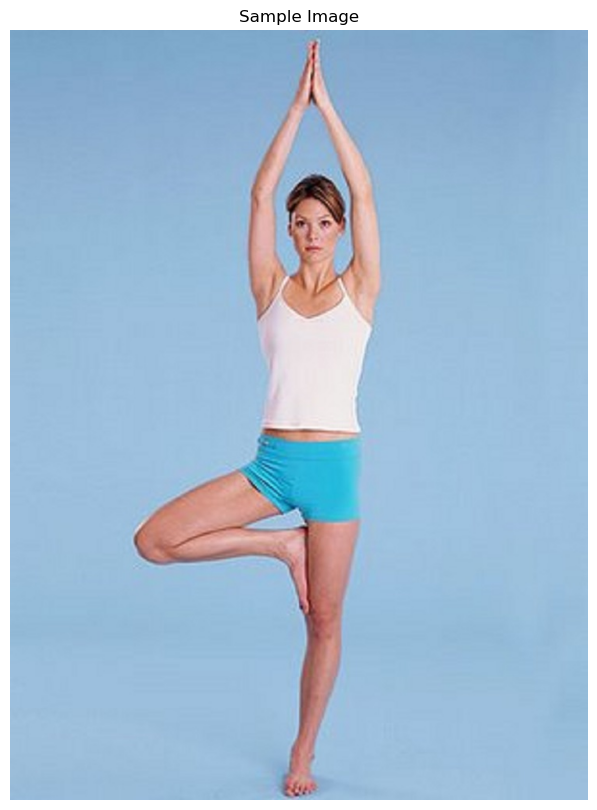

In [58]:
# Ensure you have the correct path
file_path = r'C:\dataset\yoga_set1\train\tree\5.jpg'

# Read the image using OpenCV
sample_img = cv2.imread(file_path)

# Check if the image was successfully read
if sample_img is None:
    print(f"Error: Could not read the image from the path: {file_path}")
else:
    # Display the image using Matplotlib
    plt.figure(figsize=[10, 10])
    plt.title("Sample Image")
    plt.axis('off')
    # Convert the image from BGR to RGB format
    plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
    plt.show()

In [59]:
# Perform pose detection after converting the image into RGB format.
results = pose.process(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))

# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Iterate two times as we only want to display first two landmarks.
    for i in range(2):
        
        # Display the found normalized landmarks.
        print(f'{mp_pose.PoseLandmark(i).name}:\n{results.pose_landmarks.landmark[mp_pose.PoseLandmark(i).value]}') 

NOSE:
x: 0.524999797
y: 0.266280502
z: -0.400451273
visibility: 0.993801773

LEFT_EYE_INNER:
x: 0.539016724
y: 0.24969998
z: -0.370958507
visibility: 0.995459199



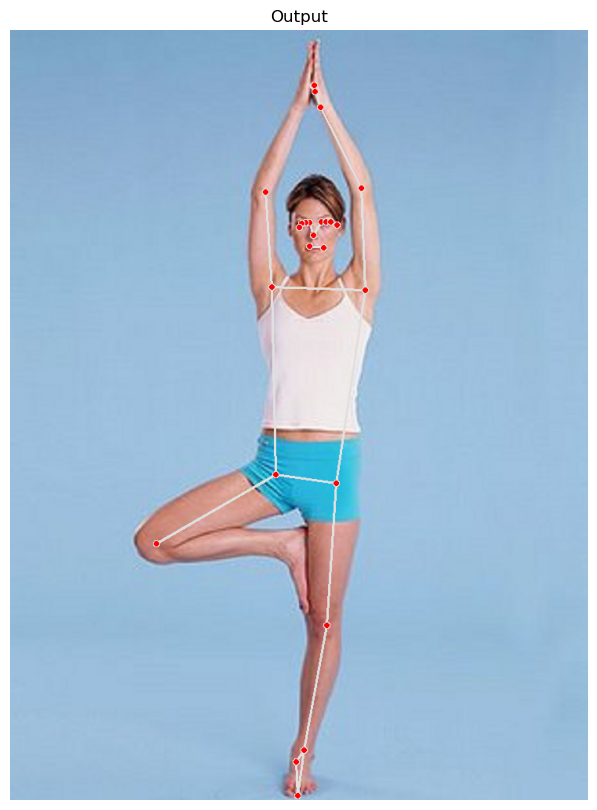

In [60]:
#model creation
# Create a copy of the sample image to draw landmarks on.
img_copy = sample_img.copy()

# Check if any landmarks are found.
if results.pose_landmarks:
    
    # Draw Pose landmarks on the sample image.
    mp_drawing.draw_landmarks(image=img_copy, landmark_list=results.pose_landmarks, connections=mp_pose.POSE_CONNECTIONS)
       
    # Specify a size of the figure.
    fig = plt.figure(figsize = [10, 10])

    # Display the output image with the landmarks drawn, also convert BGR to RGB for display. 
    plt.title("Output");plt.axis('off');plt.imshow(img_copy[:,:,::-1]);plt.show()

In [61]:
train_path = r"C:\Users\mahap\Downloads\archive (2)\DATASET\TRAIN"
test_path = r"C:\Users\mahap\Downloads\archive (2)\DATASET\TEST"

# Preprocess_Image

In [3]:
def preprocess_images(dataset_path):
    images_data = []
    images_label = []
    class_names = os.listdir(dataset_path)
    for class_name in class_names:
        images_path = dataset_path + '/' + class_name
        images = os.listdir(images_path)
        for image in images:
            bgr_img = cv2.imread(images_path + '/' + image)
            # dsize
            dsize = (64,64)
            #resize image
            resized_image = cv2.resize(bgr_img,dsize)
            # convert from BGR color-space to YCrCb
            ycrcb_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)
            # create a CLAHE object 
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            # Now apply CLAHE object on the YCrCb image
            ycrcb_img[:, :, 0] = clahe.apply(ycrcb_img[:, :, 0])
            # convert back to BGR color-space from YCrCb
            equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
            # Denoise is done to remove unwanted noise to better perform
            equalized_denoised_image = cv2.fastNlMeansDenoisingColored(equalized_img, None, 10, 10, 7, 21)
            
            images_data.append(equalized_denoised_image/255)
            images_label.append(class_name)
    images_data = np.array(images_data)
    images_label = np.array(images_label)
    return images_data, images_label

In [4]:
train_images_data, train_images_label = preprocess_images(train_path)

In [5]:
def encoding_targets(labels):
    le = preprocessing.LabelEncoder()
    images_label = le.fit_transform(labels)
    return images_label

In [6]:
class_names = os.listdir(train_path)
class_num = len(class_names)
train_images_label = encoding_targets(train_images_label)

# Creating The Model

In [7]:
model = tf.keras.Sequential([
        tfl.Conv2D(filters=16, kernel_size=(3,3), activation='relu',input_shape=(64,64,3)),
        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.25),
        
    
        tfl.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.25),    
        
    
        tfl.Flatten(),
        tfl.Dense(512,activation='relu'),
        tfl.BatchNormalization(),
        tfl.Dropout(rate=0.5),
    
        tfl.Dense(class_num, activation='softmax')])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 batch_normalization (Batch  (None, 29, 29, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)       

In [8]:
epochs = 20
learning_rate = 0.001
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# KFold

In [9]:
kfold = KFold(n_splits=5, shuffle=True,random_state=2)

In [10]:
# Define per-fold score containers
val_acc_per_fold = []
val_loss_per_fold = []
loss_per_fold = []
acc_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, valid in kfold.split(train_images_data, train_images_label):
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(train_images_data[train], train_images_label[train], batch_size=16, 
                        epochs=epochs, validation_data=(train_images_data[valid], train_images_label[valid]))
    val_acc_per_fold.append(history.history['val_accuracy'])
    acc_per_fold.append(history.history['accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])
    loss_per_fold.append(history.history['loss'])
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20


54/54 [==============================] - 14s 205ms/step - loss: 2.2763 - accuracy: 0.3947 - val_loss: 1.6769 - val_accuracy: 0.2028
Epoch 2/20
54/54 [==============================] - 10s 195ms/step - loss: 1.1266 - accuracy: 0.6354 - val_loss: 1.5524 - val_accuracy: 0.3088
Epoch 3/20
54/54 [==============================] - 10s 186ms/step - loss: 0.7321 - accuracy: 0.7535 - val_loss: 1.9611 - val_accuracy: 0.2074
Epoch 4/20
54/54 [==============================] - 10s 179ms/step - loss: 0.5106 - accuracy: 0.8322 - val_loss: 3.3653 - val_accuracy: 0.2028
Epoch 5/20
54/54 [==============================] - 9s 172ms/step - loss: 0.3230 - accuracy: 0.8993 - val_loss: 1.9593 - val_accuracy: 0.3364
Epoch 6/20
54/54 [==============================] - 10s 182ms/step - loss: 0.2852 - accuracy: 0.8912 - val_loss: 3.2855 - val_accuracy: 0.2028
Epoch 7/20
54/54 [==========================

# Accuracy

In [11]:
print(f'> Mean_Training_Accuracy: {np.mean(acc_per_fold)*100} (+- {np.std(acc_per_fold)})')
print(f'> Mean_Validation_Accuracy: {np.mean(val_acc_per_fold)*100} (+- {np.std(val_acc_per_fold)})')

> Mean_Training_Accuracy: 96.27727994322777 (+- 0.07420565012606703)
> Mean_Validation_Accuracy: 88.31607368588448 (+- 0.2032872044515787)


In [12]:
test_images_data, test_images_label = preprocess_images(test_path)
test_images_label = encoding_targets(test_images_label)
predict = np.argmax(model.predict(np.array(test_images_data)),axis=1)
print('Test Data accuracy: ',accuracy_score(test_images_label, predict)*100)
print("\nConfusion Matrix : ")
cnf_matrix = confusion_matrix(test_images_label, predict)
print(cnf_matrix)
print("\nClassification Report :")
print(classification_report(test_images_label, predict, target_names=class_names))

15/15 [==============================] - 1s 28ms/step
Test Data accuracy:  83.19148936170212

Confusion Matrix : 
[[87  2  7  1  0]
 [ 1 59  8  0 12]
 [ 1 10 93  1 10]
 [ 2  1  1 63  2]
 [ 3 13  4  0 89]]

Classification Report :
              precision    recall  f1-score   support

     downdog       0.93      0.90      0.91        97
     goddess       0.69      0.74      0.72        80
       plank       0.82      0.81      0.82       115
        tree       0.97      0.91      0.94        69
    warrior2       0.79      0.82      0.80       109

    accuracy                           0.83       470
   macro avg       0.84      0.83      0.84       470
weighted avg       0.84      0.83      0.83       470



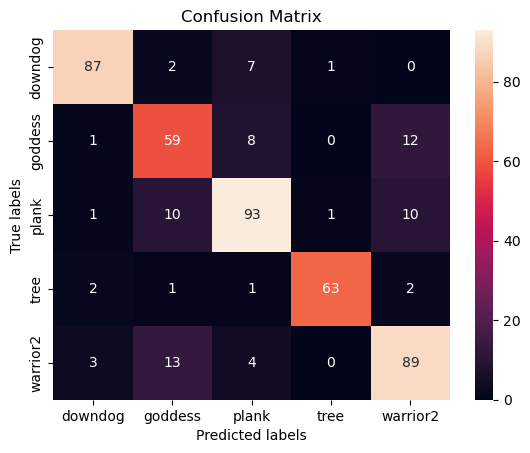

In [13]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']); ax.yaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']);

PartitionExplainer explainer: 6it [00:14,  7.45s/it]                                                                   


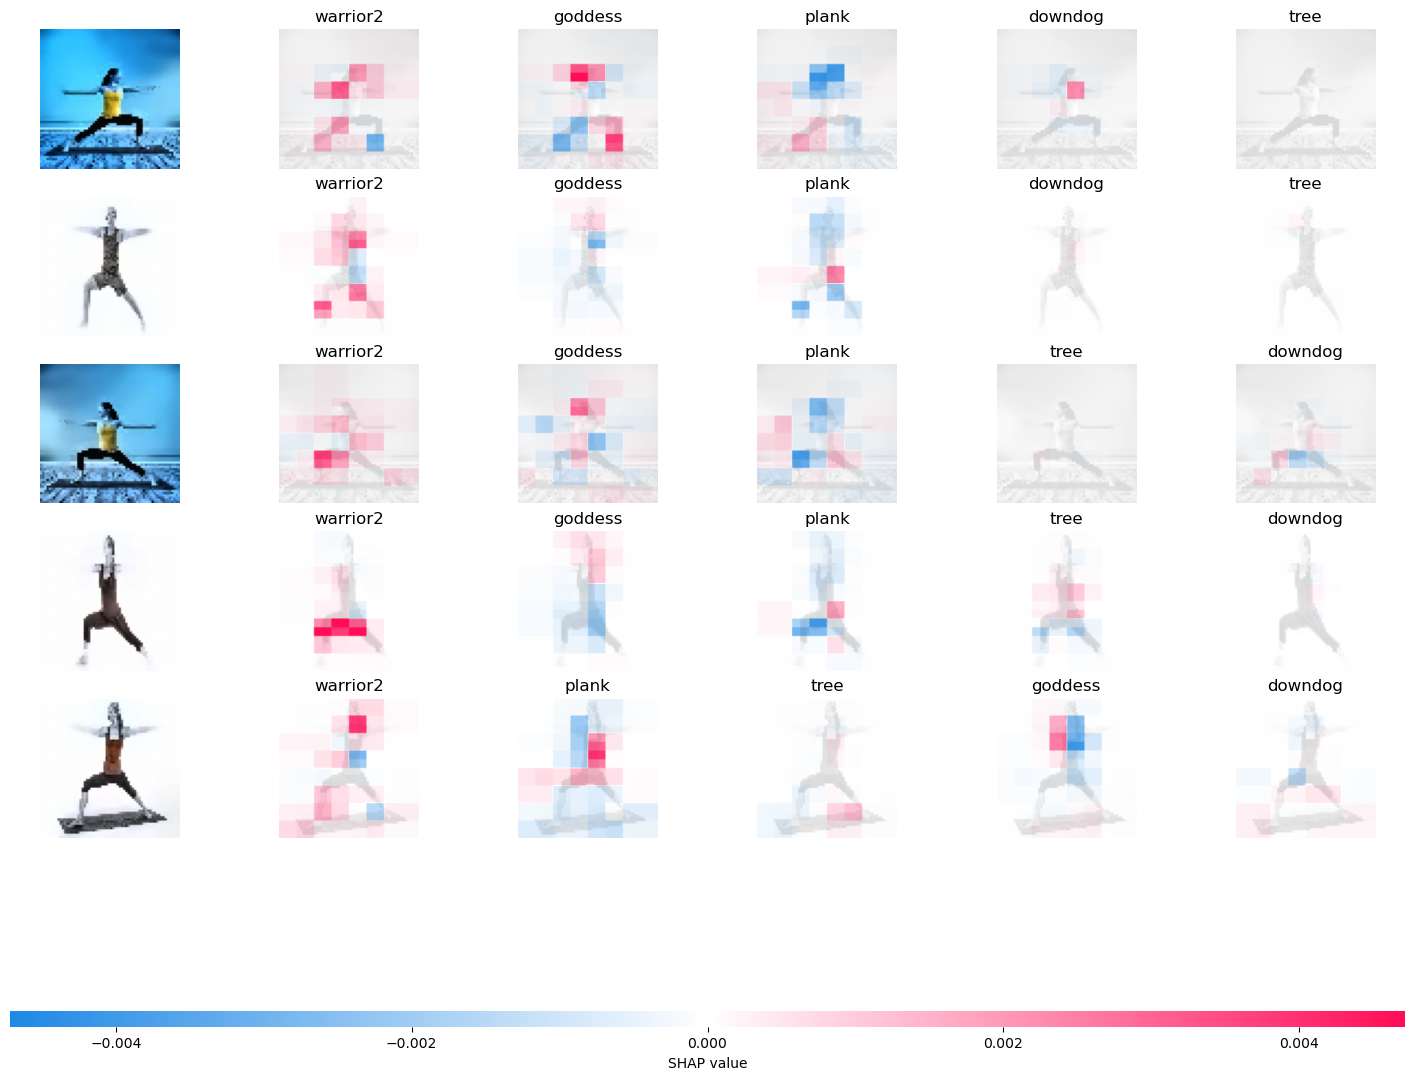

In [14]:
shap.initjs()
#Masker to mask parts of an image using blurring
masker = shap.maskers.Image("blur(64,64)", train_images_data[0].shape)
#Explainer() constructor by default creates an instance of Partition explainer
explainer = shap.Explainer(model, masker, output_names=class_names)
#generate shap values for images using the explainer object
shap_values = explainer(test_images_data[361:366], outputs=shap.Explanation.argsort.flip[:5])
shap.image_plot(shap_values)


# Random Forest Model

In [64]:
os.chdir(r"C:\Users\mahap\Downloads\archive (2)\DATASET\TRAIN")
clear_output()

In [65]:
labels=os.listdir('.')
labels

['downdog', 'goddess', 'plank', 'tree', 'warrior2']

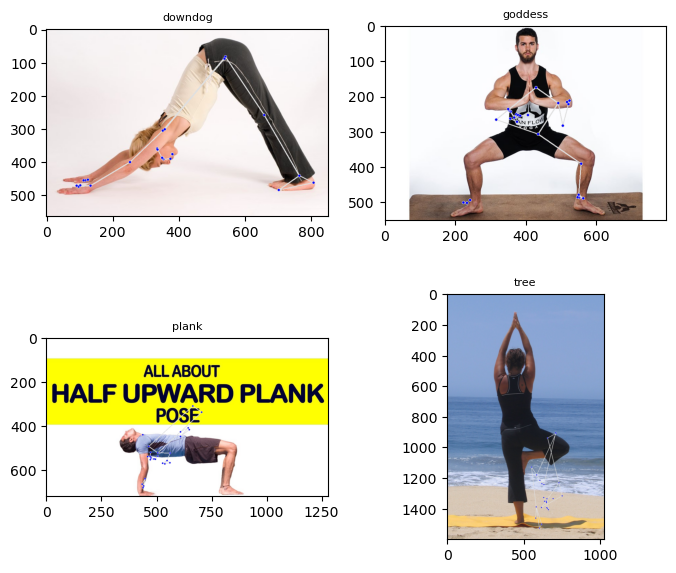

In [66]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
images=[]
for idx,data in enumerate(os.listdir('.')):
    for image in os.listdir(f'{data}'):
        image=cv2.imread(f'{data}/{image}')
        # or
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)
        try :
            landmarks = results.pose_landmarks

            for landmark in landmarks.landmark:
               x = landmark.x
               y = landmark.y

               # Do something with the coordinates
               mp_drawing = mp.solutions.drawing_utils
               mp_drawing.draw_landmarks(image_rgb, landmarks, mp_pose.POSE_CONNECTIONS)
               images.append(image_rgb)
               break
        except:
            continue
        break
    if idx==4:
        break
fig,axes=plt.subplots(2,2,figsize=(8,7))  

for i ,ax in enumerate(axes.flat) :
    ax.imshow(images[i])
    ax.set_title(labels[i],fontsize=8)

plt.show()

In [67]:
# Create a dictionary with data
data_set =defaultdict(list)

# Create a DataFrame from the dictionary
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
label_encode=[]
for idx,data in enumerate(os.listdir('.')):
    for image in os.listdir(f'{data}'):
        img=cv2.imread(f'{data}/{image}')

        image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)
        landmarks = results.pose_landmarks
        try:
            for idd,landmark in enumerate(landmarks.landmark):
               x = landmark.x
               y = landmark.y
               
               data_set[f'X {idd}']=(data_set[f'X {idd}']+[x])
               data_set[f'Y {idd}']=(data_set[f'Y {idd}']+[y])
            data_set['Labels']=(data_set['Labels']+[idx]) 
            data_set['image_Name']=(data_set['image_Name']+[image])
        except:
            pass

In [68]:
data=pd.DataFrame(data_set)
data

,X 0,Y 0,X 1,Y 1,X 2,Y 2,X 3,Y 3,X 4,Y 4,...,X 29,Y 29,X 30,Y 30,X 31,Y 31,X 32,Y 32,Labels,image_Name
0,0.441700,0.694201,0.416444,0.695569,0.413817,0.691103,0.410937,0.686189,0.416747,0.696550,...,0.948680,0.820942,0.930634,0.812978,0.825927,0.860303,0.809430,0.840739,0,00000128.jpg
1,0.378846,0.717390,0.360062,0.707027,0.359729,0.703011,0.359607,0.699168,0.359579,0.708512,...,0.931578,0.890964,0.917245,0.878799,0.794249,0.955767,0.776637,0.924903,0,00000129.jpg
2,0.394866,0.642226,0.369800,0.646245,0.367126,0.642503,0.364376,0.637901,0.369520,0.648550,...,0.944371,0.808694,0.920989,0.779360,0.806704,0.843974,0.801038,0.827370,0,00000130.jpg
3,0.569671,0.566876,0.560455,0.588558,0.558476,0.587685,0.555794,0.586915,0.556616,0.589709,...,0.942869,0.697461,0.878706,0.669932,0.848695,0.741254,0.812981,0.713256,0,00000131.jpg
4,0.507775,0.584656,0.205885,0.584777,0.257835,0.607563,0.239111,0.609885,0.361747,0.561647,...,0.553933,0.659127,0.229804,0.591788,0.566466,0.735029,0.161110,0.789532,0,00000132.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,0.481021,0.335358,0.488220,0.318708,0.491105,0.318296,0.493808,0.317839,0.482207,0.320450,...,0.661548,0.868145,0.389012,0.915906,0.680883,0.923602,0.328278,0.937932,4,00000431.jpg
960,0.338165,0.465799,0.335452,0.441915,0.335282,0.440544,0.335019,0.438202,0.336840,0.448104,...,0.798380,0.938599,0.401985,0.923382,0.823895,0.955700,0.352150,0.934189,4,00000432.png
961,0.553783,0.159025,0.563312,0.136346,0.567156,0.136686,0.571666,0.136829,0.553577,0.135854,...,0.780052,0.951329,0.471362,0.953122,0.811627,0.998490,0.404541,0.956388,4,00000433.jpg
962,0.583834,0.423733,0.585824,0.405042,0.585231,0.404723,0.584722,0.404831,0.587175,0.404842,...,0.668558,0.877422,0.772489,0.837460,0.700220,0.889933,0.760441,0.893649,4,00000434.jpg


In [69]:
data.Labels.value_counts()

4    235
2    226
0    202
1    160
3    141
Name: Labels, dtype: int64

In [70]:
target=data['Labels']
feutures=data.drop('Labels',axis=1)
X_train, X_test, y_train, y_test = train_test_split(feutures, target, test_size=0.2, random_state=42)

In [71]:
analysis_error=X_test['image_Name']
X_train.drop('image_Name',inplace=True,axis=1)
X_test.drop('image_Name',inplace=True,axis=1)

In [72]:
analysis_error

760    00000162.jpg
884    00000323.jpg
938    00000400.jpg
901    00000342.jpg
622    00000107.jpg
           ...     
552    00000381.jpg
798    00000212.jpg
33     00000170.jpg
31     00000165.jpg
718      File45.jpg
Name: image_Name, Length: 193, dtype: object

In [73]:
print('X_train shape is',X_train.shape )
print('X_test shape is',X_test.shape )
print('y_train shape is',y_train.shape )
print('y_test shape is',y_test.shape )
print('analysis_error shape is',analysis_error.shape )

X_train shape is (771, 66)
X_test shape is (193, 66)
y_train shape is (771,)
y_test shape is (193,)
analysis_error shape is (193,)


In [74]:
rf_classifier = RandomForestClassifier(n_estimators=120, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=120, random_state=42)

In [75]:
from sklearn.metrics import accuracy_score,confusion_matrix
y_pred=rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8186528497409327


In [76]:
print(confusion_matrix(y_test, y_pred))

[[32  0  0  0  1]
 [ 0 24  3  2  6]
 [ 2  1 39  0  2]
 [ 0  2  1 21  4]
 [ 0  3  5  3 42]]


In [77]:
np.sum(y_pred!=y_test)

35

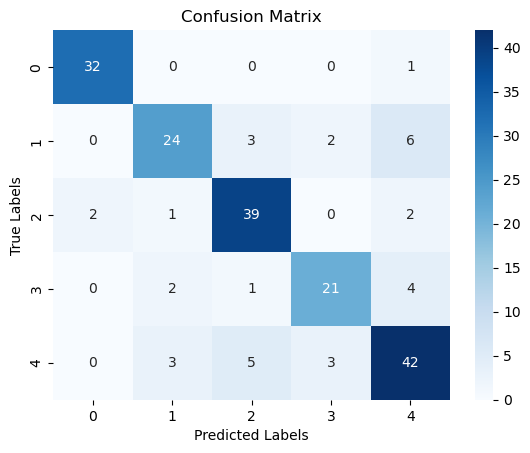

In [78]:
# Assuming you have the true labels (y_true) and predicted labels (y_pred)
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')

# Set the axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

# Thank you